# Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neural_network import MLPRegressor
import re
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datasets import concatenate_datasets, load_dataset_builder, get_dataset_config_names, load_dataset
from sklearn.svm import LinearSVC, SVC

In [2]:
# Load Social Bias Frames dataset
ds_builder = load_dataset_builder("social_bias_frames")
print(ds_builder.info.description)
configs = get_dataset_config_names("social_bias_frames")
print(configs)

# train
train_data = load_dataset("social_bias_frames", split="train")
# test
test_data = load_dataset("social_bias_frames", split="test")

Social Bias Frames is a new way of representing the biases and offensiveness that are implied in language.
For example, these frames are meant to distill the implication that "women (candidates) are less qualified"
behind the statement "we shouldn’t lower our standards to hire more women."
['default']


In [3]:
# Check if links and emojis in text
def has_links(text):
    # Define a regular expression for URLs
    url_pattern = r'https?://\S+|www\.\S+'
    return int(bool(re.search(url_pattern, text)))


def has_emojis(text):
    # Define a regular expression for emojis
    emoji_pattern = r'[\U00010000-\U0010ffff]'
    return int(bool(re.search(emoji_pattern, text)))


# Apply the custom functions to the dataset
def apply_custom_features(dataset):
    dataset = dataset.map(lambda x: {"HasLinksYN": 'Y' if has_links(x['post']) else 'N'})
    dataset = dataset.map(lambda x: {"HasEmojisYN": 'Y' if has_emojis(x['post']) else 'N'})
    return dataset

In [4]:
train_data = apply_custom_features(train_data)
test_data = apply_custom_features(test_data)

# Separate the features and labels for training and testing data
labels_tr = train_data["offensiveYN"]
data_tr = train_data.remove_columns("offensiveYN")
labels_te = test_data["offensiveYN"]
data_te = test_data.remove_columns("offensiveYN")

# Convert the dataset to a pandas DataFrame
data_tr = data_tr.to_pandas()
data_te = data_te.to_pandas()

# Step 2: Preprocess the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=10, token_pattern=r'[a-zA-Z]+')
X_train = tfidf_vectorizer.fit_transform(data_tr['post'])
X_test = tfidf_vectorizer.transform(data_te['post'])

print(X_train.shape)  # Check the shape of X_train

(112900, 10328)


In [5]:
# Combine text features and additional features
data_tr['HasLinksYN'] = data_tr['HasLinksYN'].map({'N': 0, 'Y': 1})
data_tr['HasEmojisYN'] = data_tr['HasEmojisYN'].map({'N': 0, 'Y': 1})

data_te['HasLinksYN'] = data_te['HasLinksYN'].map({'N': 0, 'Y': 1})
data_te['HasEmojisYN'] = data_te['HasEmojisYN'].map({'N': 0, 'Y': 1})

# Select only the numeric columns for converting to sparse matrix
numeric_columns_tr = ['HasLinksYN', 'HasEmojisYN'] 
numeric_columns_te = ['HasLinksYN', 'HasEmojisYN']

# Convert additional features to sparse matrix
data_tr_sparse = csr_matrix(data_tr[numeric_columns_tr].values)
data_te_sparse = csr_matrix(data_te[numeric_columns_te].values)

# Combine text features and additional features
X_combined_train = hstack([X_train, data_tr_sparse], format='csr')
X_combined_test = hstack([X_test, data_te_sparse], format='csr')

# Step 4: Prepare labels
y_train = labels_tr
y_test = labels_te

# # Define the parameter grid to search for the best 'max_depth'
# param_grid = {'max_depth': range(1, 21)}  # Searching from 1 to 20
# 
# # Initialize the decision tree classifier
# dtree = DecisionTreeClassifier(random_state=42)
#
# # Initialize GridSearchCV with cross-validation
# grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
#
# # Fit GridSearchCV on the training data
# grid_search.fit(X_combined_train, y_train)
#
# # Print the best parameter and the corresponding score from the training (cross-validation)
# print(f"Best Parameter from training: {grid_search.best_params_}")
# print(f"Best Score from training: {grid_search.best_score_}")

## Algorithms

# Decision Tree Classifier

In [6]:
# Step 5: Train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_combined_train, y_train)

# Step 6: Make Predictions on the test set
y_pred = clf.predict(X_combined_test)

# Step 7: Evaluate the Model
accuracy_dt = accuracy_score(y_test, y_pred)
report_dt = classification_report(y_test, y_pred, zero_division=0)

print(f"Decision Tree Results:")
print(f"Accuracy: {accuracy_dt}")
print("\nDecision Tree Classification Report:")
print(report_dt)

Decision Tree Results:
Accuracy: 0.6480201131363922

Decision Tree Classification Report:
              precision    recall  f1-score   support

                   0.02      0.03      0.02       232
         0.0       0.54      0.69      0.61      5500
         0.5       0.10      0.06      0.07      1230
         1.0       0.78      0.71      0.75     10539

    accuracy                           0.65     17501
   macro avg       0.36      0.37      0.36     17501
weighted avg       0.65      0.65      0.64     17501


In [7]:
# Step 8: Train the Naive Bayes Classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_combined_train, y_train)

# Step 9: Make Predictions on the test set with Naive Bayes
y_pred_nb = nb_clf.predict(X_combined_test)

# Step 10: Evaluate the Naive Bayes Model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, zero_division=0)

print("\nNaive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("\nNaive Bayes Classification Report:")
print(report_nb)


Naive Bayes Results:
Accuracy: 0.7566996171647334

Naive Bayes Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00       232
         0.0       0.67      0.75      0.71      5500
         0.5       0.00      0.00      0.00      1230
         1.0       0.81      0.86      0.83     10539

    accuracy                           0.76     17501
   macro avg       0.37      0.40      0.39     17501
weighted avg       0.70      0.76      0.72     17501


# MLP Classifier,
Using SVD first
Looping based on learning rate, 300 iterations

In [8]:
# Standardize the features before feeding them into MLP
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

acc = []
#MLP Hyperparameters
# MLPlearn = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]
MLPlearn = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1]
svd = TruncatedSVD(n_components=20)
trunc = svd.fit_transform(X_train_scaled)
trunc_test = svd.transform(X_test_scaled)

for lr in MLPlearn:
    # Train the Multi-layer Perceptron Classifier
    mlp_clf = MLPClassifier(random_state=1, activation='relu', max_iter=300, learning_rate='adaptive', learning_rate_init=lr)
    mlp_clf.fit(trunc, y_train)
    
    # Make Predictions on the test set with MLP
    y_pred_mlp = mlp_clf.predict(trunc_test)
    accuracy_sc = accuracy_score(y_test, y_pred_mlp)
    acc.append(accuracy_sc)

# # Evaluate the MLP Model
# accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
# report_mlp = classification_report(y_test, y_pred_mlp, zero_division=0)
# 
# print("\nMulti-layer Perceptron Results")
# print(f"Accuracy: {accuracy_mlp}")
# print("\nMulti-layer Perceptron Classification Report:")
# print(report_mlp)

C:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


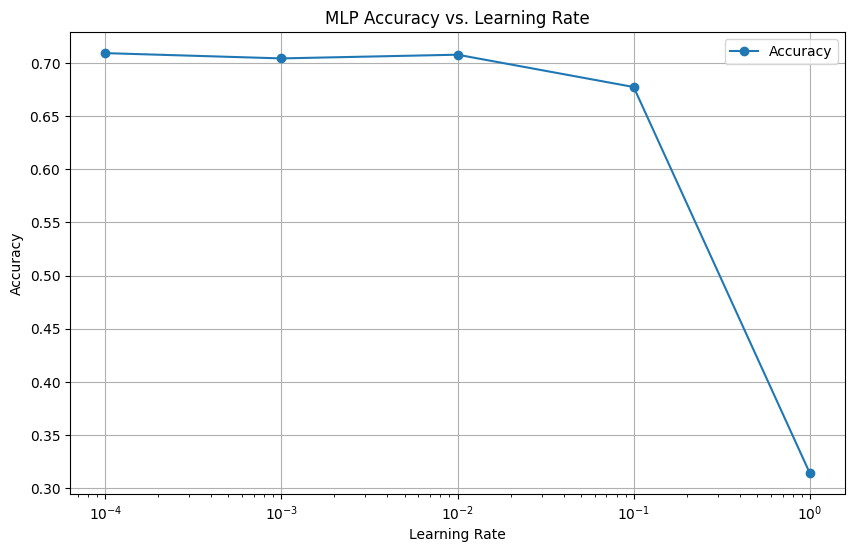

In [9]:
# Plot the results
#max iteration 300
plt.figure(figsize=(10, 6))
plt.plot(MLPlearn, acc, marker='o', label='Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy vs. Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

# MLP Classifier,
Using SVD first
Looping based on iterations,
learning rate 10e-3

In [ ]:
# Standardize the features before feeding them into MLP
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

acc = []
#MLP Hyperparameters
# MLPlearn = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7]
# MLPlearn = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1]
it = [10, 50, 100, 200, 300]
svd = TruncatedSVD(n_components=20)
trunc = svd.fit_transform(X_train_scaled)
trunc_test = svd.transform(X_test_scaled)

for itera in it:
    # Train the Multi-layer Perceptron Classifier
    mlp_clf = MLPClassifier(random_state=1, activation='relu', max_iter=itera, learning_rate='adaptive', learning_rate_init=10e-3)
    mlp_clf.fit(trunc, y_train)
    
    # Make Predictions on the test set with MLP
    y_pred_mlp = mlp_clf.predict(trunc_test)
    accuracy_sc = accuracy_score(y_test, y_pred_mlp)
    acc.append(accuracy_sc)

C:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Plotting Vs. Learning Rate

In [ ]:
# Plot the results
#max iteration 300
plt.figure(figsize=(10, 6))
plt.plot(it, acc, marker='o', label='Accuracy')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Log Regression Classifier
looping on solver


In [ ]:
s = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
acc = []

for sol in s:
    # Train the Logistic Regression Classifier
    log_reg = LogisticRegression(max_iter=1000, solver=sol)
    log_reg.fit(X_train, y_train)
    
    # Make Predictions on the test set with Logistic Regression
    y_pred_lr = log_reg.predict(X_test)
    
    # Evaluate the Logistic Regression Model
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    report_lr = classification_report(y_test, y_pred_lr, zero_division=0)
    acc.append(accuracy_lr)

print("\nLogistic Regression Results")
print(f"Accuracy: {accuracy_lr}")
print("\nLogistic Regression Classification Report:")
print(report_lr)

In [ ]:
# Plot the results
#max iteration 300
plt.figure(figsize=(10, 6))
plt.bar(s, acc, label='Accuracy')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.title('Logistic Accuracy vs. Solver')
plt.legend()
plt.grid(True)
plt.show()

# Svm Classifier


In [ ]:
# Step 11: Train the SVM Classifier
# Initialize the SVM classifier with a linear kernel
svm_clf = LinearSVC(dual=False, tol=1e-4, max_iter=2000)

# Ensure data is scaled
X_train_scaled = scaler.fit_transform(X_combined_train)
X_test_scaled = scaler.transform(X_combined_test)

# Fit the SVM classifier on the scaled training data
svm_clf.fit(X_train_scaled, y_train)

# Make Predictions on the scaled test set with SVM
y_pred_svm = svm_clf.predict(X_test_scaled)

# Evaluate the SVM Model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, zero_division=0)

# Print SVM results
print("\nSVM Results:")
print(f"Accuracy: {accuracy_svm}")
print("\nSVM Classification Report:")
print(report_svm)

In [ ]:
kernels = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
# Ensure data is scaled
X_train_scaled = scaler.fit_transform(X_combined_train)
X_test_scaled = scaler.transform(X_combined_test)
acc = []
for k in kernels:
    svmclf = make_pipeline(StandardScaler(), SVC(kernel=k, gamma='auto'))
    svmclf.fit(X_train_scaled, y_train)
    # Make Predictions on the scaled test set with SVM
    y_pred_svm = svm_clf.predict(X_test_scaled)
    
    # Evaluate the SVM Model
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    report_svm = classification_report(y_test, y_pred_svm, zero_division=0)
    acc.append(accuracy_svm)

In [ ]:
# Plot the results
#max iteration 300
plt.figure(figsize=(10, 6))
plt.bar(k, acc, label='Accuracy')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Vs. Kernel')
plt.legend()
plt.grid(True)
plt.show()